In [360]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

# creat a Dataframe for each course with the following columns:
    major 
    courseTitle
    courseNumber
    Hours
    geneds
    prerequisites
    description

In [361]:
all_courses = requests.get('https://www.luther.edu/catalog/curriculum')

In [362]:
acct = requests.get("https://www.luther.edu/catalog/curriculum/accounting/")

In [363]:
soup = BeautifulSoup(all_courses.text, 'html.parser')

In [364]:
#soup.select("div.courseContainer")

In [365]:
dept_list = soup.select('ul.childrenList a')
major_list = []
for item in dept_list:
    dept = item.get('href', 'None')
    if dept != 'None':
        major_list.append(dept)

In [366]:
df = pd.DataFrame(columns=['Major', 'coursTitle', 'courseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])

In [367]:
sites =[]
for item in major_list:
    main = 'https://www.luther.edu/catalog/curriculum/{}'.format(item)
    sites.append(main)

In [368]:
#hour_pre_list = soup.select ("div.courseContainer i")
#for hour in hour_pre_list:
    #print(hour.get('class','None'))
  

In [369]:
#dept_list = soup.select ("ul.childrenList a")
#for dept in dept_list:
    #dept_list = dept.get('href','None')
    #print(dept_list)
    

In [370]:
#Course_list = soup.select ("div.courseContainer span")
#for course in Course_list:
    #print(course.get('class','None'))
  

In [371]:
def find_classes(my_soup,row):
    dept = my_soup.find_all('h1', class_='pageTitle')[0].text
    courses = my_soup.find_all('div', class_='courseContainer')
    for item in courses:
        course_title = item.find_all('span', class_='courseTitle')[0].text
        course_number = item.find_all('span', class_='courseNumber')[0].text
        credit_hours = item.find_all('li')[0].text
        for part in item.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereqs = part.text.split(' ')[1:]
                prereqs = ' '.join(prereqs)
            else:
                prereqs = ''
        description = item.find_all('span', class_='courseDescription')[0].text
        geneds = []
        for content in item.find_all('span', class_='genEd'):
            geneds.append(content.text)
        gened_string = ', '.join(geneds)
        df.loc[row] = [dept, course_title, course_number, credit_hours, gened_string, prereqs, description]
        row += 1
    return row

In [372]:
row = 0
for item in major_list:
    this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
    soup = BeautifulSoup(this_course.text, 'html.parser')
    row = find_classes(soup, row)

In [373]:
df.head(1)

Major                  coursTitle courseNumber    Hours GenEds  \
0  Accounting  Introduction to Accounting    ACCTG 110  2 hours          

                            Prereqs  \
0  First-year or sophomore standing   

                                         Description  
0  A course specifically for students who have ha...

In [374]:
new_list = []
alist = []
import re
for item in df.Prereqs:
    new_list.append(re.findall(r'[A-Z][A-Z][A-Z]+', item))
for item in new_list:
    alist.append(item)
    
code_df = pd.DataFrame(columns= ['code', 'conn'])

code_df['code'] = df.courseNumber.map(lambda x : x.split(' ')[0])

code_df['conn'] = alist

In [375]:
connect = code_df.conn.apply(pd.Series).stack().reset_index(level =1, drop=True)
connect.name = 'conn'
code_df = code_df.drop('conn', axis=1).join(connect)
code_df = code_df.reset_index(drop = True)
code_df = code_df.drop_duplicates()
code_df = code_df.reset_index(drop = True)
code_df = code_df.dropna(how='any')
code_df = code_df.reset_index(drop = True)

# PREREQS relation


In [376]:
g = nx.DiGraph()
g.add_nodes_from(code_df.code)
for index, row in code_df.iterrows():
    g.add_edge(row['code'], row['conn'])

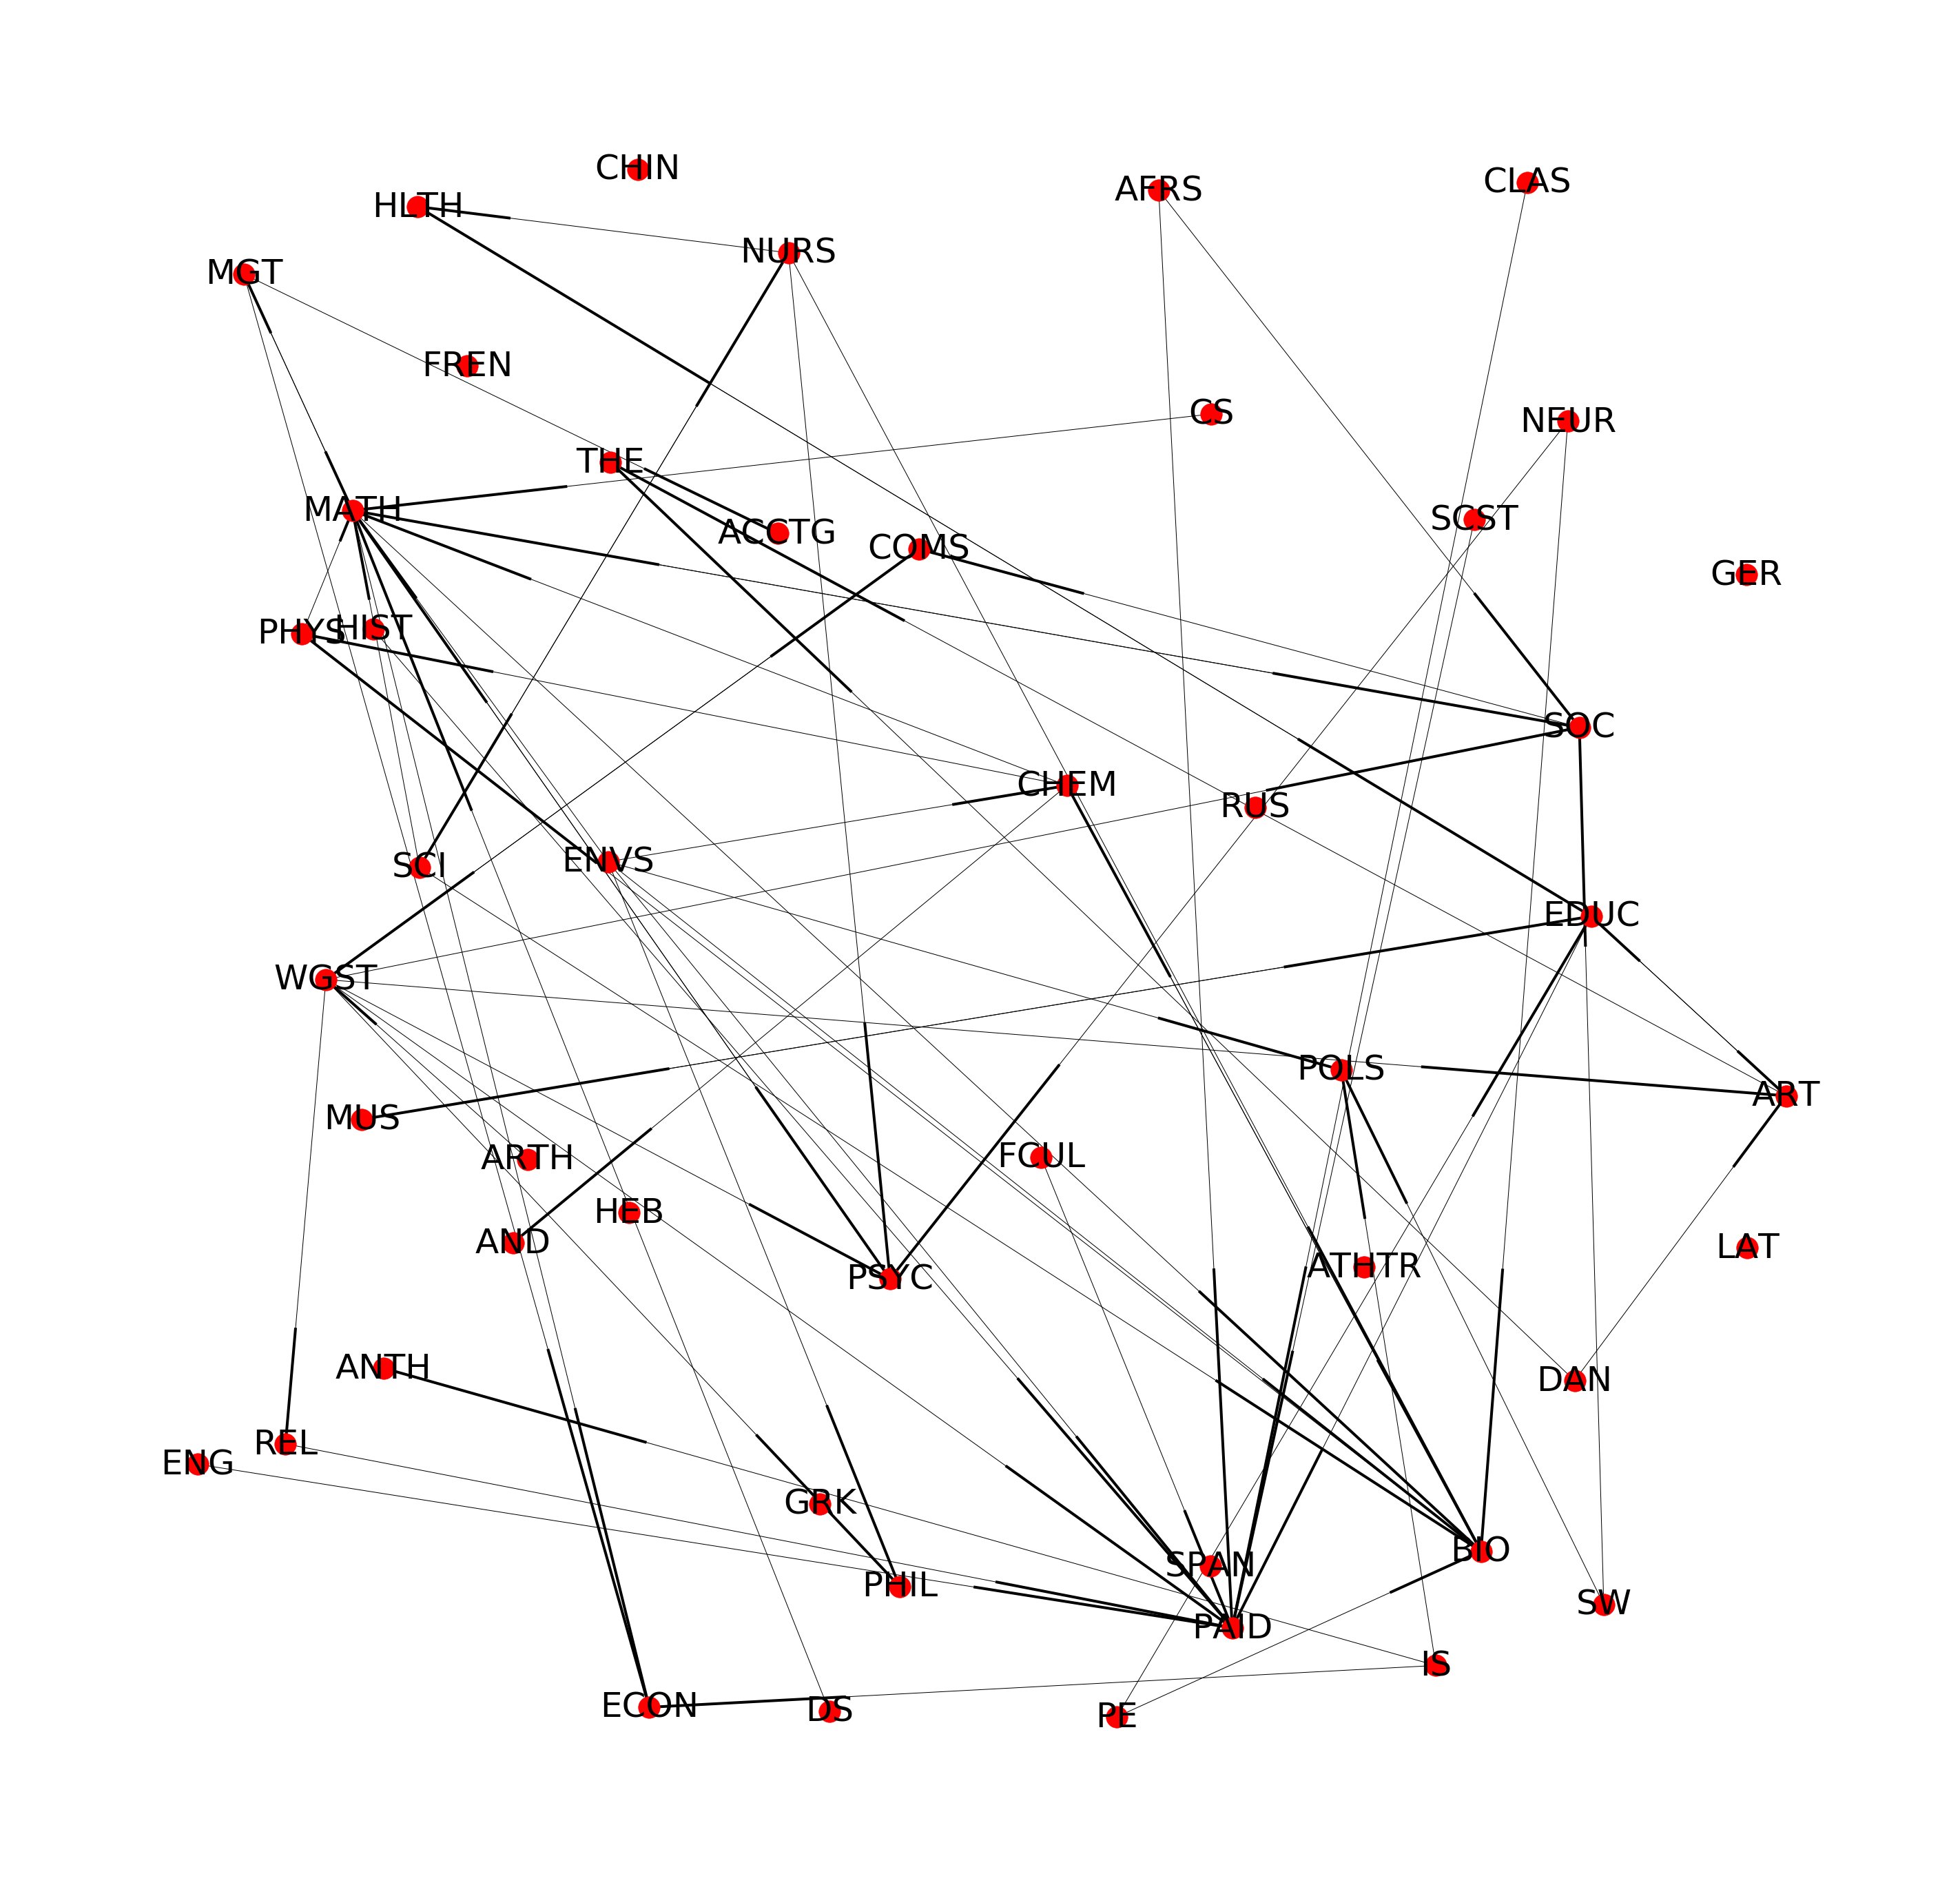

In [377]:
gfig, gax = plt.subplots(figsize = (50,50))
#pos = nx.spring_layout(g, k=.5, iterations=1, scale=10, center=(0,0))
#nx.draw(hego, pos, ax=gax, node_size=5000, with_labels=True, font_size=80)
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 1000)



In [378]:
try:
    for item in major_list:
        this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
        soup = BeautifulSoup(this_course.text, 'html.parser')
        list3 = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            this = soup.find_all('div', class_='catalog_block')
            that = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for item in this:
            item = item.text
            list3.append(item)
        if len(that) > 1 :
            that = that.split(' ')
        that.pop()
        that = ''.join(that)
        list4 = []
        for item in list3:
            list4.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', item))
        combining = [item for sublist in list4 for item in sublist]
        lst = []
        for item in combining:
            item = item.split(' ')
            lst.append(item)

        for item in lst:
            del item[1]
        lst = [item for sublist in lst for item in sublist]
        lst = set(lst)
        lst = list(lst)
        df1.set_value(-1, 'code', that)
        df1.set_value(-1, 'relation', lst)
        df1 = df1.reset_index(drop=True)
except:
    print(item)

['ACCTG']


In [379]:
connect = code_df.conn.apply(pd.Series).stack().reset_index(level = 1, drop=True)
connect.name = 'conn'
code_df = code_df.drop('conn', axis=1).join(connect)
code_df = code_df.drop_duplicates()
code_df = code_df.sort_values(by=['code'])
code_df = code_df.replace('', np.nan, regex=True)
code_df = code_df.replace('^AND', np.nan, regex=True)
code_df = code_df.dropna(how='any')
code_df = code_df.reset_index(drop = True)

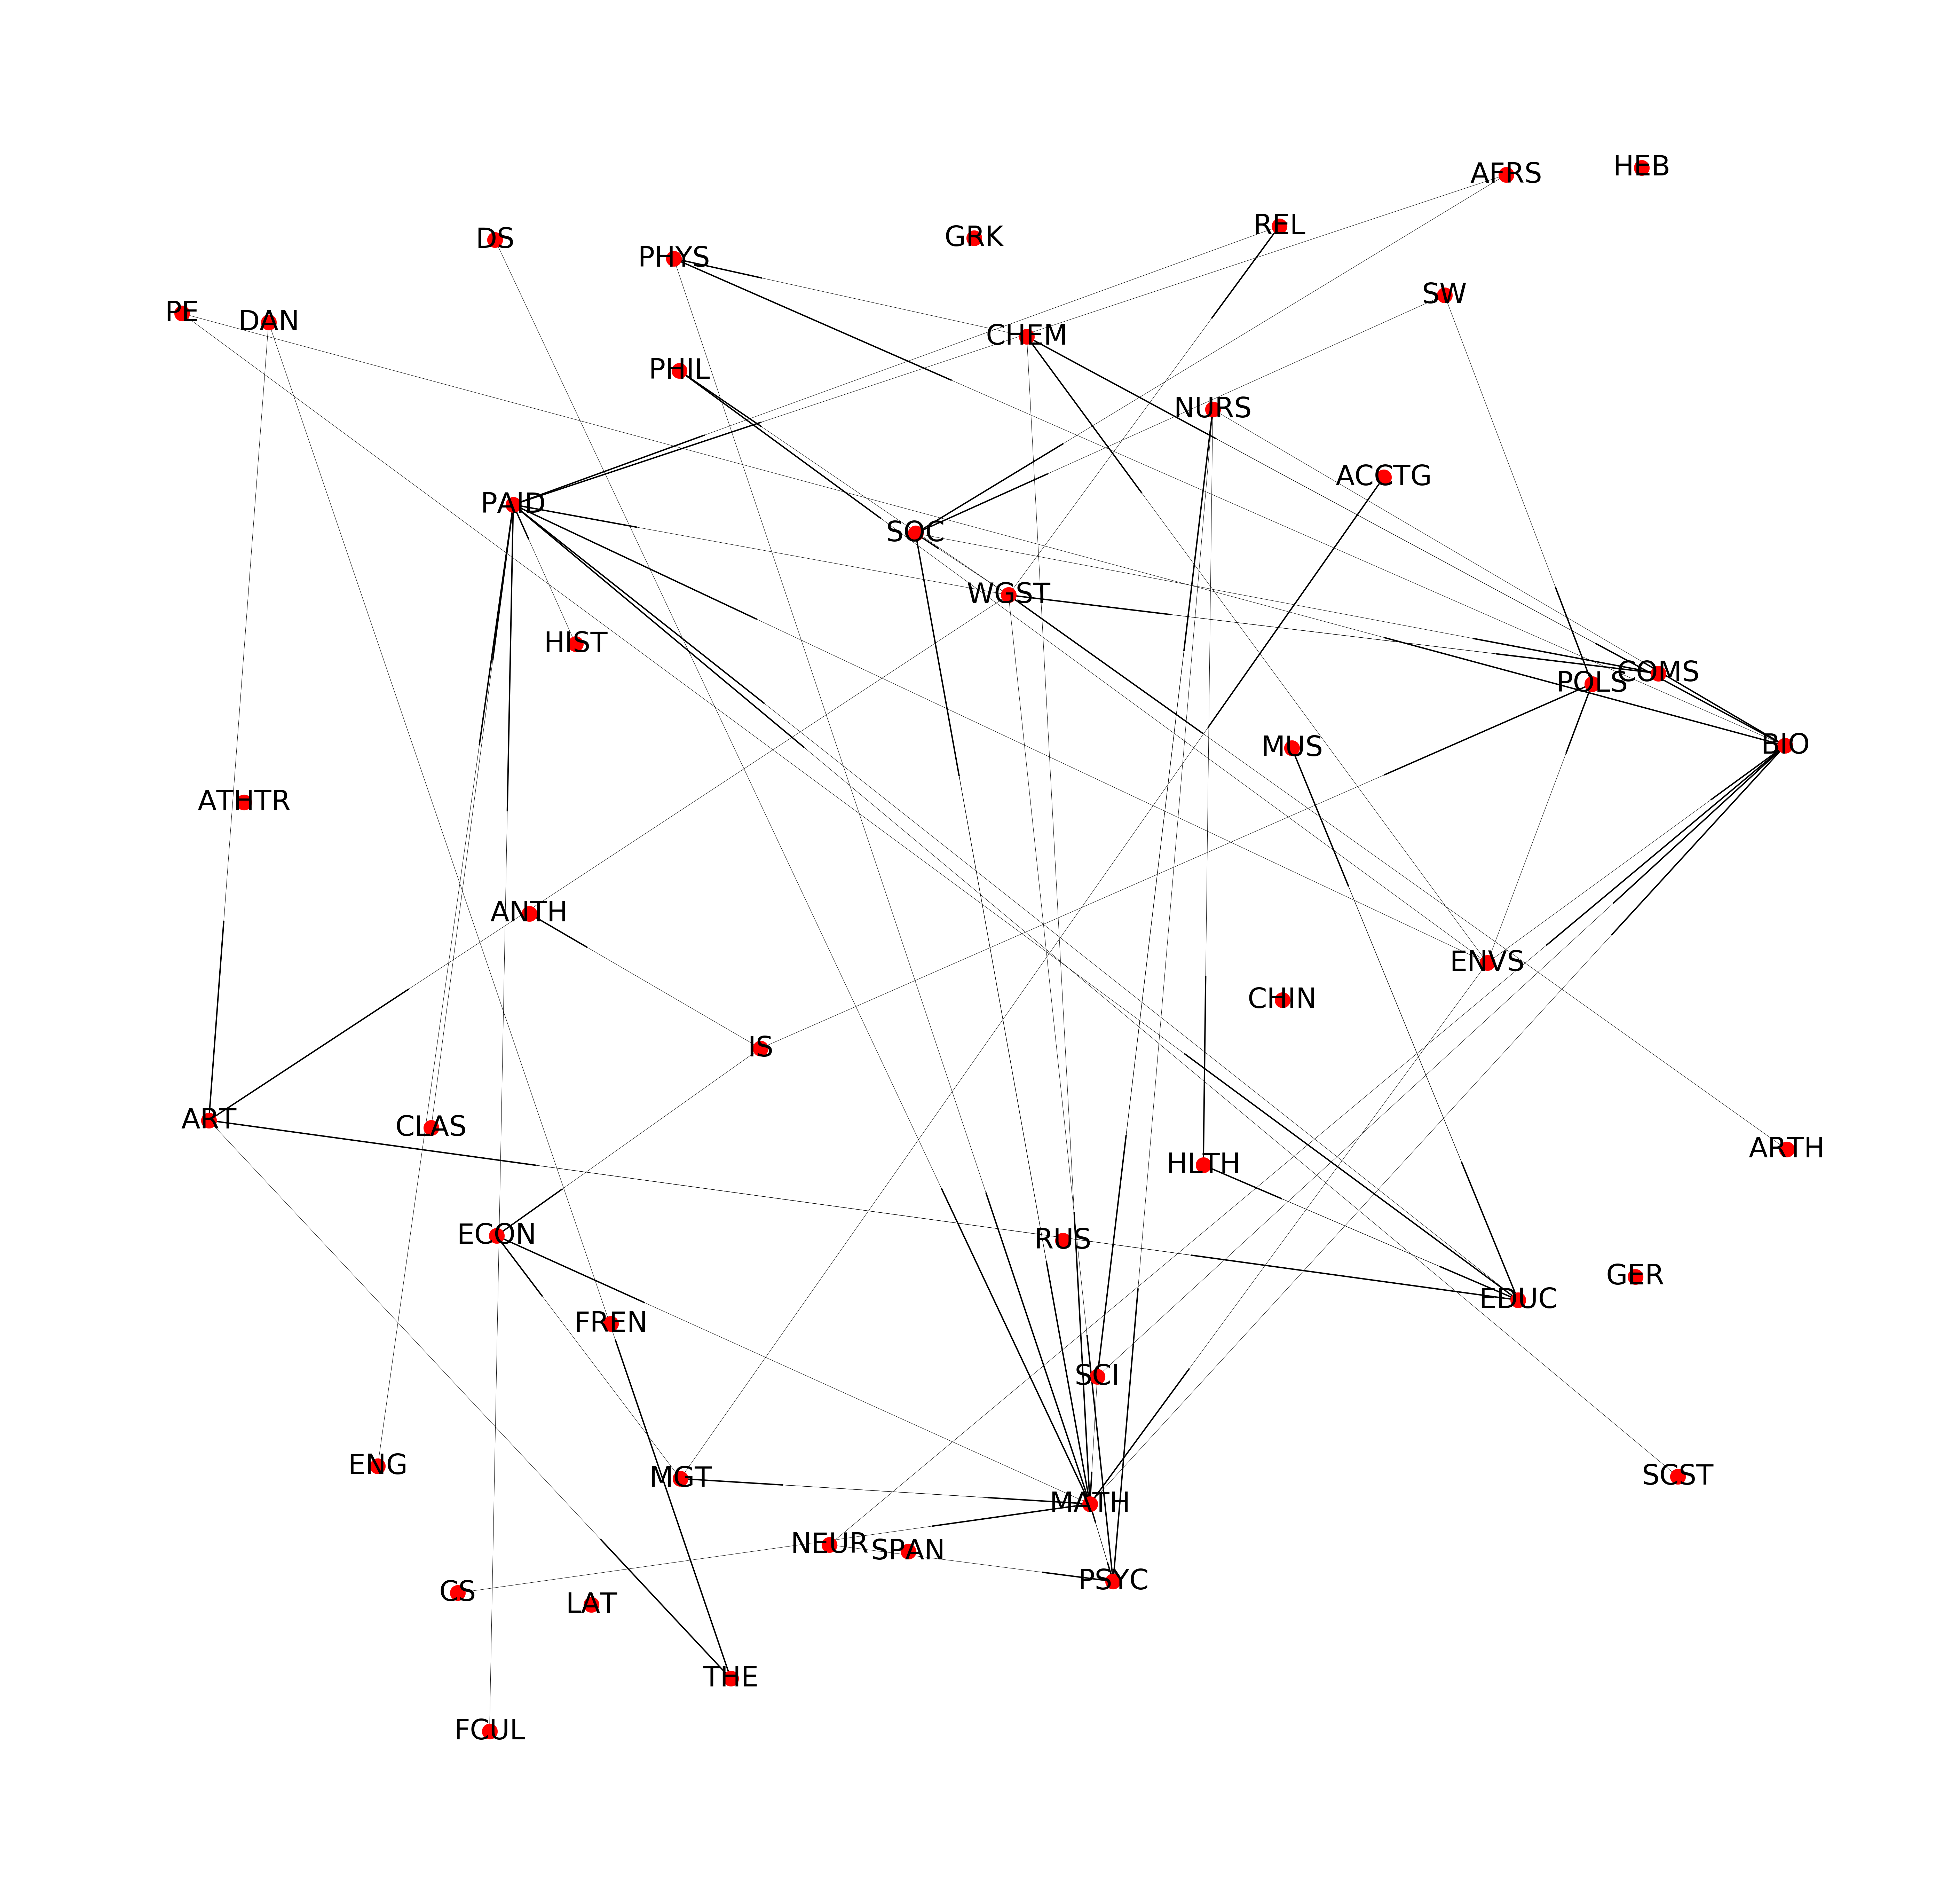

In [380]:
g = nx.DiGraph()
g.add_nodes_from(code_df.code)
for index, row in code_df.iterrows():
    g.add_edge(row['code'], row['conn'])
        
gfig, gax = plt.subplots(figsize = (100,100))
nx.draw(g,nx.spring_layout(g, k=0.5, iterations = 1), ax=gax, with_labels = True, font_size = 80, node_size =2000)


# non-prerequisite required for a major


In [381]:
code_df.groupby('conn')['code'].count().head()

conn
ACCTG    2
ANTH     2
ART      4
ARTH     1
ATHTR    1
Name: code, dtype: int64

In [382]:
code_df.groupby('conn')['code'].count().head(5) > 5

conn
ACCTG    False
ANTH     False
ART      False
ARTH     False
ATHTR    False
Name: code, dtype: bool